<font size="5"> CS6364/CS4364: Assignment 2</font><br>
<font size="5"> Part: 2 </font><br>
<font size="5"> EmotionLines: Dialogue Emotion Dataset </font><br>
<font size="4"> Sagar Sheth </font>

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
import nltk
import json
from nltk import pos_tag
import string
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import cluster

In [2]:
file_path = 'friends_train.json'

with open(file_path, 'r') as file:
    data = json.load(file)

flat_data = [utterance for conversation in data for utterance in conversation]


df = pd.DataFrame(flat_data)
df

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030
...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011
10558,Joey,"You guys are messing with me, right?",surprise,0000050
10559,All,Yeah.,neutral,4000010


In [3]:
df.isnull().sum()

speaker       0
utterance     0
emotion       0
annotation    0
dtype: int64

### Performing Tokenization and Lemmatization along with removal of stop words

In [4]:

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    
    return [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in string.punctuation] if not filtered_words else filtered_words

df['tokenize_text'] = df['utterance'].apply(tokenize_text)

print(df[['utterance', 'tokenize_text']])


                                               utterance  \
0      also I was the point person on my companys tr...   
1                       You mustve had your hands full.   
2                                That I did. That I did.   
3          So lets talk a little bit about your duties.   
4                                 My duties?  All right.   
...                                                  ...   
10556                                         You or me?   
10557  I got it. Uh, Joey, women don't have Adam's ap...   
10558               You guys are messing with me, right?   
10559                                              Yeah.   
10560  That was a good one. For a second there, I was...   

                                   tokenize_text  
0      [also, point, person, transition, system]  
1                                   [hand, full]  
2                   [that, i, did, that, i, did]  
3                      [talk, little, bit, duty]  
4                       

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalnum()]
    words = [word.lower() for word in words if word.lower() not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


df['processed_text'] = df['utterance'].apply(process_text)

print(df[['utterance', 'processed_text']])

                                               utterance  \
0      also I was the point person on my companys tr...   
1                       You mustve had your hands full.   
2                                That I did. That I did.   
3          So lets talk a little bit about your duties.   
4                                 My duties?  All right.   
...                                                  ...   
10556                                         You or me?   
10557  I got it. Uh, Joey, women don't have Adam's ap...   
10558               You guys are messing with me, right?   
10559                                              Yeah.   
10560  That was a good one. For a second there, I was...   

                            processed_text  
0      also point person transition system  
1                                hand full  
2                                           
3                     talk little bit duty  
4                               duty right  
...      

### Distribution of Emotion

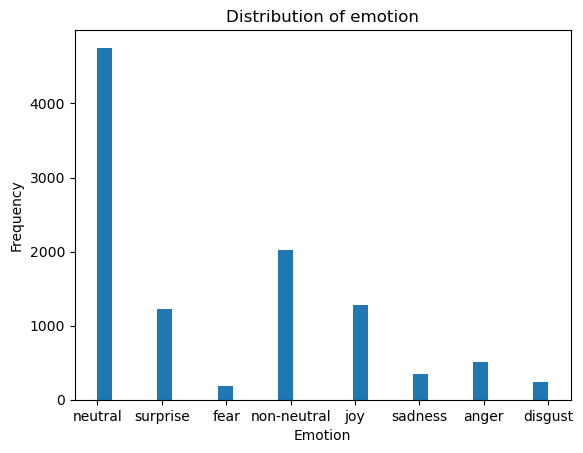

speaker           4752
utterance         4752
emotion           4752
annotation        4752
tokenize_text     4752
processed_text    4752
dtype: int64

In [73]:
plt.hist(df['emotion'], bins=30)
plt.title('Distribution of emotion')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()
df[df['emotion'] == 'neutral'].count()

### Plotting the Top 20 most frequent words

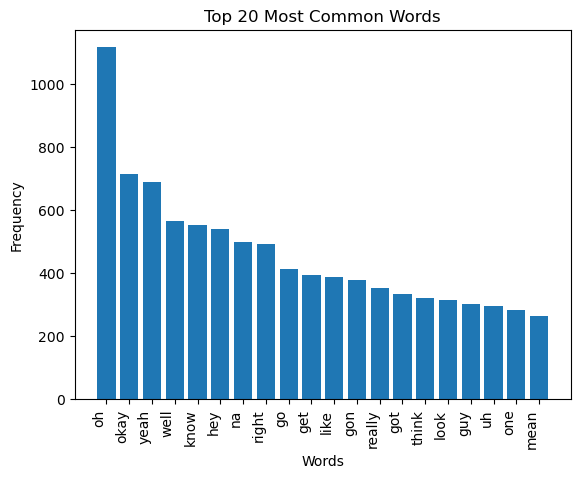

In [7]:
all_processed_words = [word for words_list in df['tokenize_text'] for word in words_list]

word_frequencies = Counter(all_processed_words)

top_n = 20 
top_words, top_frequencies = zip(*word_frequencies.most_common(top_n))

plt.bar(top_words, top_frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words')
plt.xticks(rotation=90, ha='right')
plt.show()

C:\Users\sagar\AppData\Local\Temp\ipykernel_1812\3043747688.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


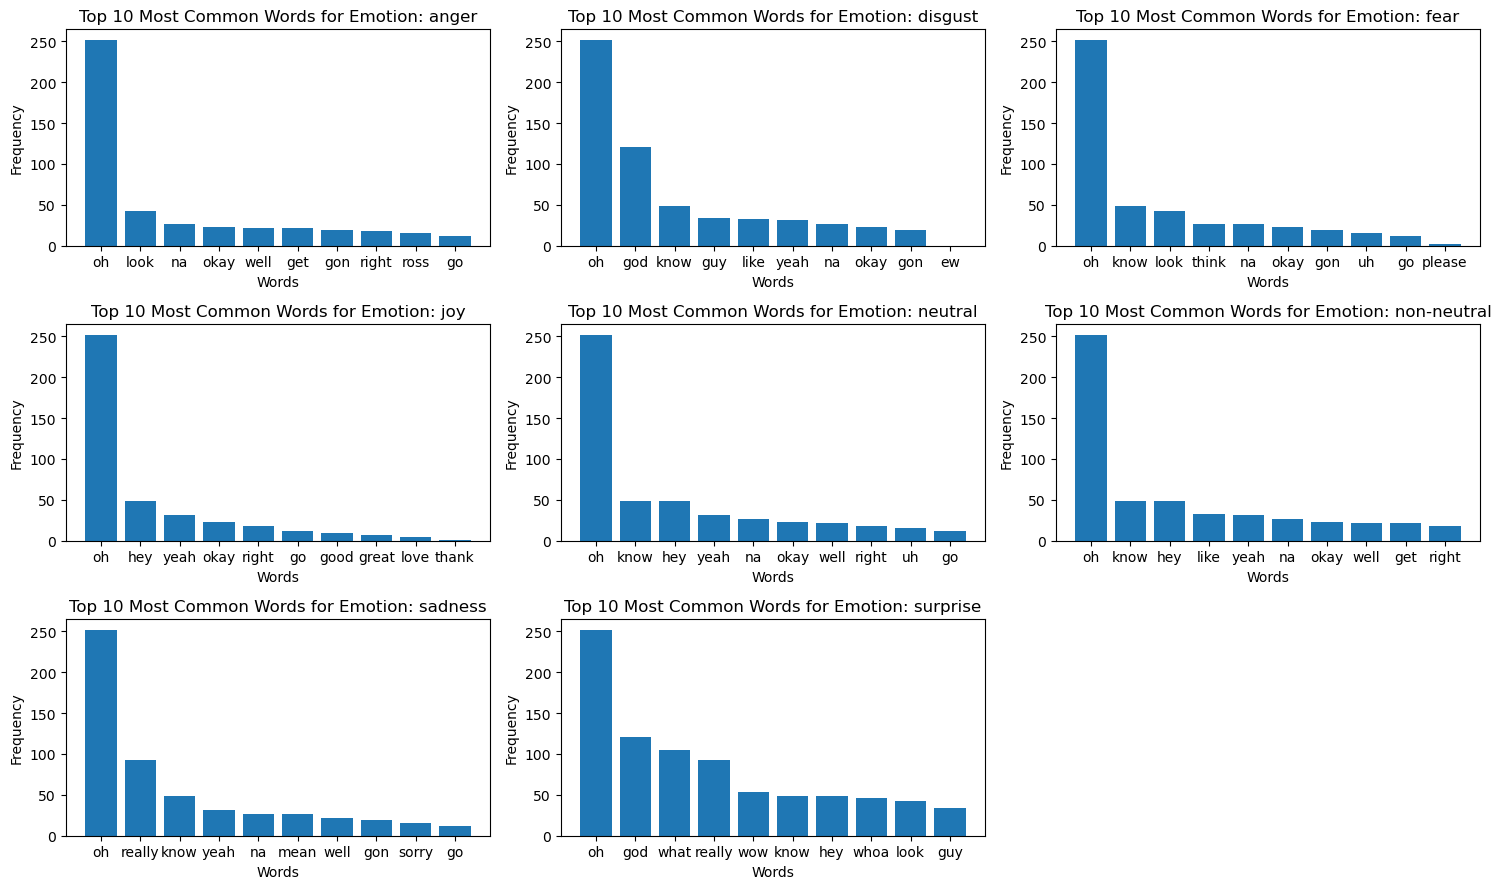

In [8]:
top_words_by_emotion = {}
grouped_df = df.groupby('emotion')
for emotion, group in grouped_df:
    all_processed_words = [word for words_list in group['tokenize_text'] for word in words_list]
    word_frequencies = Counter(all_processed_words)
    top_n = 10
    top_words = [word for word, _ in word_frequencies.most_common(top_n)]

    top_words_by_emotion[emotion] = top_words

num_rows = (len(top_words_by_emotion) + 2) // 3
plots_per_row = 3

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 3 * num_rows))
fig.tight_layout(pad=3.0)

axes = axes.flatten()

for i, (emotion, top_words) in enumerate(top_words_by_emotion.items()):
    ax = axes[i]
    sorted_word_frequencies = sorted(
        ((word, word_frequencies[word]) for word in top_words),
        key=lambda x: x[1],
        reverse=True
    )
    
    sorted_words, sorted_frequencies = zip(*sorted_word_frequencies)
    ax.bar(sorted_words, sorted_frequencies)
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Top {top_n} Most Common Words for Emotion: {emotion}')

for i in range(len(top_words_by_emotion), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Applying TFID to convert String to Number

In [9]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])
df_tf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df = df.reset_index(drop=True)
df_tf = df_tf.reset_index(drop=True)

df2 = pd.concat([df, df_tf], axis=1)
df2

,speaker,utterance,emotion,annotation,tokenize_text,processed_text,10,100,110,112,...,zelda,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic
0,Chandler,also I was the point person on my companys tr...,neutral,4100000,"[also, point, person, transition, system]",also point person transition system,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Interviewer,You mustve had your hands full.,neutral,5000000,"[hand, full]",hand full,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Chandler,That I did. That I did.,neutral,5000000,"[that, i, did, that, i, did]",,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000,"[talk, little, bit, duty]",talk little bit duty,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Chandler,My duties? All right.,surprise,2000030,"[duty, right]",duty right,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011,"[you, or, me]",,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011,"[got, uh, joey, woman, adam, apple]",got uh joey woman adam apple,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10558,Joey,"You guys are messing with me, right?",surprise,0000050,"[guy, messing, right]",guy messing right,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10559,All,Yeah.,neutral,4000010,[yeah],yeah,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Target Variable from Emotion

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df2['emotion_numerical'] = label_encoder.fit_transform(df['emotion'])

print(df2[['emotion', 'emotion_numerical']])

print("Mapping of Original Emotion Values to Numerical Values:")
for original_value, numerical_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {numerical_value}")


           emotion  emotion_numerical
0          neutral                  4
1          neutral                  4
2          neutral                  4
3          neutral                  4
4         surprise                  7
...            ...                ...
10556      neutral                  4
10557  non-neutral                  5
10558     surprise                  7
10559      neutral                  4
10560  non-neutral                  5

[10561 rows x 2 columns]
Mapping of Original Emotion Values to Numerical Values:
anger: 0
disgust: 1
fear: 2
joy: 3
neutral: 4
non-neutral: 5
sadness: 6
surprise: 7


### Generating the Target Variable and Features and converting them into numpy arrays

In [11]:
y_train=df2['emotion_numerical'].values
x_train=df2.drop(['emotion','speaker','utterance','annotation','processed_text','tokenize_text'],axis=1).values


In [12]:
y_train.shape

(10561,)

In [13]:
x_train.shape

(10561, 4687)

### Running the SVC Model

In [16]:
clf_ovr = OneVsRestClassifier(SVC())

# Train the classifier
clf_ovr.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC())

### Using the SVC Model to predict the train data

In [17]:
y_pred_ovr = clf_ovr.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred_ovr))

Accuracy: 1.0


### Classification Report

In [18]:
print("Classification Report:")
print(classification_report(y_train, y_pred_ovr))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       513
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       185
           3       1.00      1.00      1.00      1283
           4       1.00      1.00      1.00      4752
           5       1.00      1.00      1.00      2017
           6       1.00      1.00      1.00       351
           7       1.00      1.00      1.00      1220

    accuracy                           1.00     10561
   macro avg       1.00      1.00      1.00     10561
weighted avg       1.00      1.00      1.00     10561



### Generating the Linear SVC Model

In [14]:
from sklearn.svm import LinearSVC
model = LinearSVC()

# train the model
model.fit(x_train, y_train)

C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

### Using the SVC Model To predict train data

In [15]:
y_pred_ovr2 = model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred_ovr2))

Accuracy: 0.8457532430641038


### Classification Report

In [16]:
print("Classification Report:")
print(classification_report(y_train, y_pred_ovr2))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       513
           1       0.99      0.82      0.90       240
           2       0.96      0.43      0.60       185
           3       0.85      0.66      0.75      1283
           4       0.78      0.95      0.86      4752
           5       0.89      0.64      0.74      2017
           6       0.90      0.77      0.83       351
           7       1.00      1.00      1.00      1220

    accuracy                           0.85     10561
   macro avg       0.92      0.78      0.83     10561
weighted avg       0.86      0.85      0.84     10561



### Importing Test and Holdout dataset and predicting the data

### Test

### Import the data from .JSON file and cnverting into a pandas DF

In [17]:
file_path = 'friends_test.json'

with open(file_path, 'r') as file:
    data = json.load(file)

flat_data = [utterance for conversation in data for utterance in conversation]


df_test = pd.DataFrame(flat_data)
df_test

,speaker,utterance,emotion,annotation
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011
2,Rachel,Y'know what?,neutral,3000020
3,Ross,It didnt.,neutral,5000000
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010
...,...,...,...,...
2759,Phoebe,"Hey, why dont you guys go get portraits done ...",neutral,5000000
2760,Monica,Thats a good idea! I bet they have one of tho...,joy,1400000
2761,Phoebe,"Yeah thats great! Next to that, Chandler won...",neutral,3100100
2762,Monica,Chandler what do you say?,neutral,5000000


In [18]:
df_test.isnull().sum()

speaker       0
utterance     0
emotion       0
annotation    0
dtype: int64

### Performing Tokenization and Lemmatization along with removal of stop words

In [19]:
df_test['processed_text'] = df_test['utterance'].apply(process_text)

print(df_test[['utterance', 'processed_text']])

                                              utterance  \
0     Why do all youre coffee mugs have numbers on ...   
1     Oh. Thats so Monica can keep track. That way ...   
2                                          Y'know what?   
3                                            It didnt.   
4     Okay, so what you used to have with Rachel, is...   
...                                                 ...   
2759  Hey, why dont you guys go get portraits done ...   
2760  Thats a good idea! I bet they have one of tho...   
2761  Yeah thats great! Next to that, Chandler won...   
2762                          Chandler what do you say?   
2763  All right, but I should warn you, Im not goin...   

                                         processed_text  
0                              coffee mug number bottom  
1     oh monica keep track way one missing like numb...  
2                                                        
3                                                        
4

### Generating the tfidf_matrix

In [20]:

tfidf_matrix = tfidf_vectorizer.transform(df_test['processed_text'])
df_tf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(df_tf.shape)
df_test = df_test.reset_index(drop=True)
df_tf = df_tf.reset_index(drop=True)

df_test2 = pd.concat([df_test, df_tf], axis=1)
df_test2

(2764, 4687)


,speaker,utterance,emotion,annotation,processed_text,10,100,110,112,12,...,zelda,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030,coffee mug number bottom,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011,oh monica keep track way one missing like numb...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Rachel,Y'know what?,neutral,3000020,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ross,It didnt.,neutral,5000000,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010,okay used rachel got alice,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,Phoebe,"Hey, why dont you guys go get portraits done ...",neutral,5000000,hey guy go get portrait done professional phot...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2760,Monica,Thats a good idea! I bet they have one of tho...,joy,1400000,good idea bet one wind machine,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2761,Phoebe,"Yeah thats great! Next to that, Chandler won...",neutral,3100100,yeah great next chandler look stupid,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2762,Monica,Chandler what do you say?,neutral,5000000,chandler say,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_tf.shape

(2764, 4687)

### Generating the Numerical Values for the Target Variable Emotion

In [ ]:
df_test2['emotion_numerical'] = df_test2['emotion'].map({'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'non-neutral':5,
       'sadness':6, 'surprise':7})
print(df_test2[['emotion','emotion_numerical']])

In [24]:
df_test2

,speaker,utterance,emotion,annotation,processed_text,10,100,110,112,12,...,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic,emotion_numerical
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030,coffee mug number bottom,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011,oh monica keep track way one missing like numb...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,Rachel,Y'know what?,neutral,3000020,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,Ross,It didnt.,neutral,5000000,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010,okay used rachel got alice,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,Phoebe,"Hey, why dont you guys go get portraits done ...",neutral,5000000,hey guy go get portrait done professional phot...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2760,Monica,Thats a good idea! I bet they have one of tho...,joy,1400000,good idea bet one wind machine,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2761,Phoebe,"Yeah thats great! Next to that, Chandler won...",neutral,3100100,yeah great next chandler look stupid,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2762,Monica,Chandler what do you say?,neutral,5000000,chandler say,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [25]:
df_test2.isnull().sum()

speaker              0
utterance            0
emotion              0
annotation           0
processed_text       0
                    ..
zone                 0
zoo                  0
zuchoff              0
zygomatic            0
emotion_numerical    0
Length: 4693, dtype: int64

In [26]:
df_test3=df_test2.dropna()
df_test3.isnull().sum()
df_test3

,speaker,utterance,emotion,annotation,processed_text,10,100,110,112,12,...,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic,emotion_numerical
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030,coffee mug number bottom,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011,oh monica keep track way one missing like numb...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,Rachel,Y'know what?,neutral,3000020,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,Ross,It didnt.,neutral,5000000,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010,okay used rachel got alice,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,Phoebe,"Hey, why dont you guys go get portraits done ...",neutral,5000000,hey guy go get portrait done professional phot...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2760,Monica,Thats a good idea! I bet they have one of tho...,joy,1400000,good idea bet one wind machine,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2761,Phoebe,"Yeah thats great! Next to that, Chandler won...",neutral,3100100,yeah great next chandler look stupid,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2762,Monica,Chandler what do you say?,neutral,5000000,chandler say,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### Generating the target variable and features and then converting them into numpy arrays to perform prediction

In [27]:
y_test=df_test3['emotion_numerical'].values
x_test=df_test3.drop(['emotion','speaker','utterance','annotation','processed_text'],axis=1).values

In [28]:
y_test

array([7, 5, 4, ..., 4, 4, 4], dtype=int64)

In [29]:
x_test

array([[0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 4.],
       ...,
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 4.]])

### Prediction using the clf_ovr SVM Model

In [85]:
y_pred_ovr_test = clf_ovr.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_ovr_test))


Accuracy: 0.05824891461649783


### Classification Report for the clf_ove SVM Model

In [34]:
print("Classification Report:")
print(classification_report(y_test, y_pred_ovr_test))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.06      1.00      0.11       161
         1.0       0.00      0.00      0.00        68
         2.0       0.00      0.00      0.00        32
         3.0       0.00      0.00      0.00       304
         4.0       0.00      0.00      0.00      1287
         5.0       0.00      0.00      0.00       541
         6.0       0.00      0.00      0.00        85
         7.0       0.00      0.00      0.00       286

    accuracy                           0.06      2764
   macro avg       0.01      0.12      0.01      2764
weighted avg       0.00      0.06      0.01      2764



C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### Predicting Using the Linear SVM Model

In [30]:
y_pred_ovr_test2 = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_ovr_test2))

Accuracy: 0.6544862518089725


### Classification Report for the Linear SVM Model

In [31]:
print("Classification Report:")
print(classification_report(y_test, y_pred_ovr_test2))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       161
           1       0.79      0.22      0.34        68
           2       0.14      0.03      0.05        32
           3       0.50      0.34      0.40       304
           4       0.63      0.84      0.72      1287
           5       0.43      0.27      0.33       541
           6       0.49      0.24      0.32        85
           7       1.00      0.99      1.00       286

    accuracy                           0.65      2764
   macro avg       0.62      0.49      0.52      2764
weighted avg       0.63      0.65      0.63      2764



### Confusion Matrix

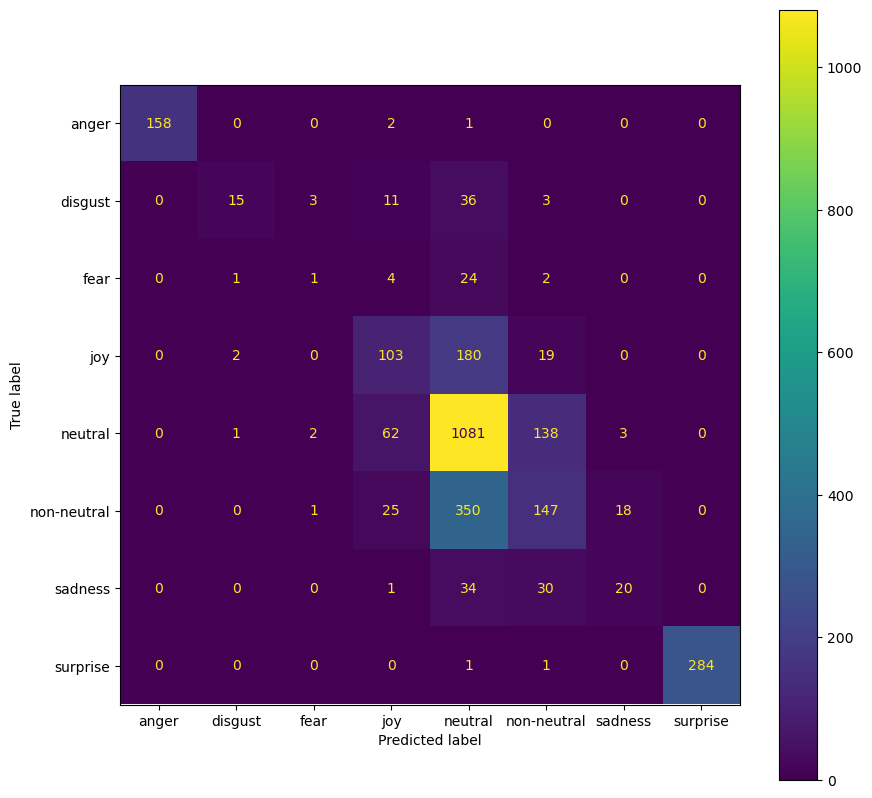

In [63]:
conf_matrix_test = confusion_matrix(y_test, y_pred_ovr_test2)
class_labels=['anger', 'disgust', 'fear', 'joy', 'neutral', 'non-neutral', 'sadness', 'surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

### Holdout

### Extracting the Holdout Set from the .JSON File and converting it into a DF.

In [32]:
file_path = 'friends_dev.json'

with open(file_path, 'r') as file:
    data = json.load(file)

flat_data = [utterance for conversation in data for utterance in conversation]


df_holdout = pd.DataFrame(flat_data)
df_holdout

,speaker,utterance,emotion,annotation
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120
1,Monica,What?,surprise,1000130
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200
3,Chandler,Youre a genius!,joy,0500000
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100
...,...,...,...,...
1173,Monica,No.,sadness,2030000
1174,Rachel,What? Oh my God! Im gonna miss you so much!,sadness,0040010
1175,Monica,Im gonna miss you!,sadness,0050000
1176,Rachel,I mean its the end of an era!,sadness,0050000


In [34]:
df_holdout.isnull().sum()

speaker       0
utterance     0
emotion       0
annotation    0
dtype: int64

### Performing Tokenization and Lemmatization along with removal of stop words

In [35]:
df_holdout['processed_text'] = df_holdout['utterance'].apply(process_text)

print(df_holdout[['utterance', 'processed_text']])

                                              utterance  \
0        Oh my God, hes lost it. Hes totally lost it.   
1                                                 What?   
2     Or! Or, we could go to the bank, close our acc...   
3                                      Youre a genius!   
4               Aww, man, now we wont be bank buddies!   
...                                                 ...   
1173                                                No.   
1174       What? Oh my God! Im gonna miss you so much!   
1175                                Im gonna miss you!   
1176                     I mean its the end of an era!   
1177                                            I know!   

                              processed_text  
0                   oh god lost totally lost  
1                                             
2     could go bank close account cut source  
3                                     genius  
4                         aww man bank buddy  
...      

### Generating the tfidf_matrix

In [36]:

tfidf_matrix = tfidf_vectorizer.transform(df_holdout['processed_text'])
df_tf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(df_tf.shape)
df_holdout = df_holdout.reset_index(drop=True)
df_tf = df_tf.reset_index(drop=True)

df_holdout2 = pd.concat([df_holdout, df_tf], axis=1)
df_holdout2

(1178, 4687)


,speaker,utterance,emotion,annotation,processed_text,10,100,110,112,12,...,zelda,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120,oh god lost totally lost,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Monica,What?,surprise,1000130,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200,could go bank close account cut source,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Chandler,Youre a genius!,joy,0500000,genius,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100,aww man bank buddy,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,Monica,No.,sadness,2030000,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1174,Rachel,What? Oh my God! Im gonna miss you so much!,sadness,0040010,oh god gon na miss much,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1175,Monica,Im gonna miss you!,sadness,0050000,gon na miss,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1176,Rachel,I mean its the end of an era!,sadness,0050000,mean end era,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df_tf.shape

(1178, 4687)

### Converting the Target Variable into Numerical Values

In [38]:
df_holdout2['emotion_numerical'] = df_holdout2['emotion'].map({'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'non-neutral':5,
       'sadness':6, 'surprise':7})
print(df_holdout2[['emotion','emotion_numerical']])

          emotion  emotion_numerical
0     non-neutral                  5
1        surprise                  7
2         neutral                  4
3             joy                  3
4         sadness                  6
...           ...                ...
1173      sadness                  6
1174      sadness                  6
1175      sadness                  6
1176      sadness                  6
1177      sadness                  6

[1178 rows x 2 columns]


In [42]:
df_holdout2

,speaker,utterance,emotion,annotation,processed_text,10,100,110,112,12,...,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic,emotion_numerical
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120,oh god lost totally lost,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,Monica,What?,surprise,1000130,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200,could go bank close account cut source,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,Chandler,Youre a genius!,joy,0500000,genius,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100,aww man bank buddy,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,Monica,No.,sadness,2030000,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1174,Rachel,What? Oh my God! Im gonna miss you so much!,sadness,0040010,oh god gon na miss much,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1175,Monica,Im gonna miss you!,sadness,0050000,gon na miss,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1176,Rachel,I mean its the end of an era!,sadness,0050000,mean end era,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [43]:
df_holdout2.isnull().sum()

speaker              0
utterance            0
emotion              0
annotation           0
processed_text       0
                    ..
zone                 0
zoo                  0
zuchoff              0
zygomatic            0
emotion_numerical    0
Length: 4693, dtype: int64

In [44]:
df_holdout3=df_holdout2.dropna()
df_holdout3.isnull().sum()
df_holdout3

,speaker,utterance,emotion,annotation,processed_text,10,100,110,112,12,...,zelner,zero,zillionaire,zinfandel,zip,zone,zoo,zuchoff,zygomatic,emotion_numerical
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120,oh god lost totally lost,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,Monica,What?,surprise,1000130,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200,could go bank close account cut source,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,Chandler,Youre a genius!,joy,0500000,genius,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100,aww man bank buddy,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,Monica,No.,sadness,2030000,,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1174,Rachel,What? Oh my God! Im gonna miss you so much!,sadness,0040010,oh god gon na miss much,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1175,Monica,Im gonna miss you!,sadness,0050000,gon na miss,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1176,Rachel,I mean its the end of an era!,sadness,0050000,mean end era,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


### Generating the Target Variable and features and converting them into numpy arrays for prediction


In [45]:
y_holdout=df_holdout3['emotion_numerical'].values
x_holdout=df_holdout3.drop(['emotion','speaker','utterance','annotation','processed_text'],axis=1).values

In [46]:
y_holdout

array([5, 7, 4, ..., 6, 6, 6], dtype=int64)

In [47]:
x_holdout

array([[0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 4.],
       ...,
       [0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 6.]])

### Predicting Using the Linear SVM

In [48]:
y_pred_ovr_holdout2 = model.predict(x_holdout)

print("Accuracy:", accuracy_score(y_holdout, y_pred_ovr_holdout2))

Accuracy: 0.6426146010186757


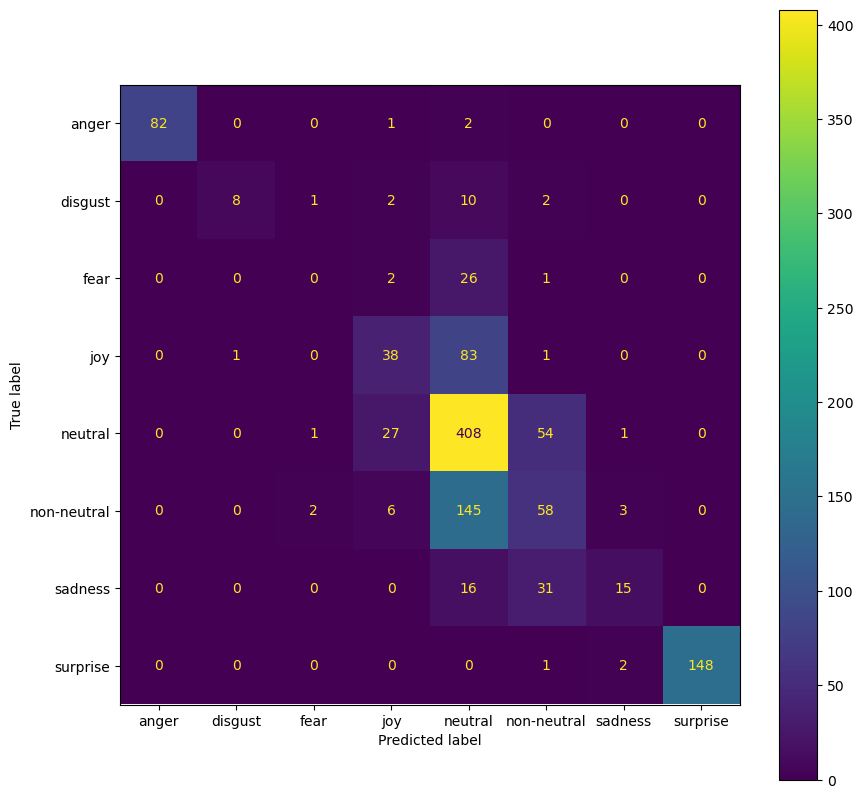

In [61]:
conf_matrix_holdout = confusion_matrix(y_holdout, y_pred_ovr_holdout2)
class_labels=['anger', 'disgust', 'fear', 'joy', 'neutral', 'non-neutral', 'sadness', 'surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_holdout,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

#### Learning Curve

In [ ]:
dt=[]
train_accr=[]
test_accr=[]

for i in range(100,len(x_train),100):
    df2= X_train.sample(n=i)
    ytr = y_train.loc[df2.index]
    model = LinearSVC()
    model.fit(df2, ytr)
    ypred1 = model.predict(Xhold)
    ypred2 = model.predict(Xval)
    li1.append(i)
    li2.append( accuracy_score(yhold, ypred1))
    li3.append( accuracy_score(Yval, ypred2))

In [82]:
train_acr=[]
test_acr=[]
holdout_acr=[]
dt=[]
for i in range (100,len(y_train),500):
    train1=x_train[:i,]
    ytrain2=y_train[:i]
    model = LinearSVC()
    model.fit(train1, ytrain2)
    train_pred=model.predict(train1)
    test_pred = model.predict(x_test)
    holdout_pred = model.predict(x_holdout)
    dt.append(i)
    train_acr.append(accuracy_score(ytrain2, train_pred))
    test_acr.append(accuracy_score(y_test, test_pred))
    holdout_acr.append(accuracy_score(y_holdout, holdout_pred))

C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sagar\AppData\Roaming\Python\Python311

In [83]:
base_line=np.ones(len(dt))*0.4499

Text(0.5, 1.0, 'Learning\xa0Curve')

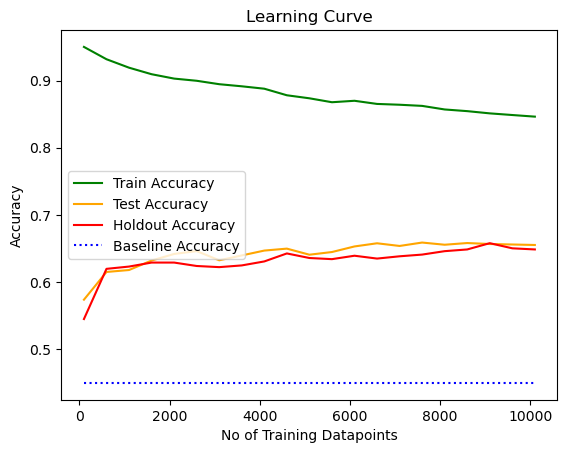

In [84]:
plt.plot(dt,train_acr, color='green', label='Train Accuracy')
plt.plot(dt,test_acr, color='orange', label='Test Accuracy')
plt.plot(dt,holdout_acr, color='red', label='Holdout Accuracy')
plt.plot(dt, base_line, linestyle='dotted', color='b', label='Baseline Accuracy')

plt.legend()
plt.xlabel('No of Training Datapoints')
plt.ylabel('Accuracy')
plt.title('Learning Curve')

### K Means

In [86]:
Ks, objs = range(1,9), []
for k in Ks:
    model = cluster.KMeans(n_clusters=k)
    model.fit(x_train)
    objs.append(-model.score(x_train))

C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sagar\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

Text(0, 0.5, 'Objective Function Value')

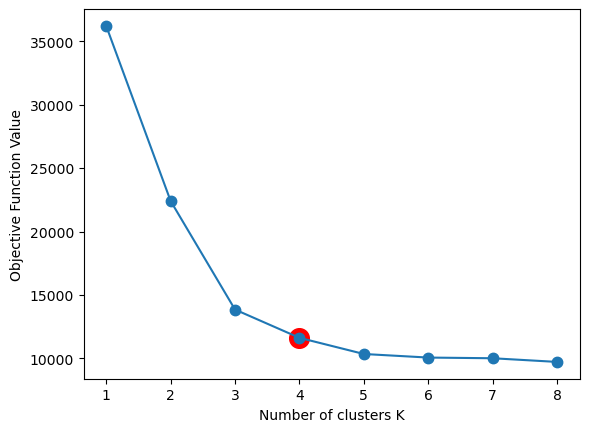

In [90]:
plt.plot(Ks, objs, '.-', markersize=15)
plt.scatter([4], [objs[3]], s=200, c='r')
plt.xlabel("Number of clusters K")
plt.ylabel("Objective Function Value")